In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
path = os.path.join("House")
def load_csv(path,filename):
    return pd.read_csv(os.path.join(filename))


In [3]:
train_data = load_csv(path,"train.csv")
train_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
def relative_attribute_sale(attribute,train_data):
    return pd.DataFrame(train_data.groupby(by= attribute)['SalePrice'].mean().reset_index().sort_values(by = "SalePrice",ascending = True))

In [6]:
set(train_data["Alley"].isna())

{False, True}

In [7]:
na_list = set([i if len(set(train_data[i].isna())) == 2 else 0 for i in list(train_data)])
na_list.remove(0)
na_list

{'Alley',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtQual',
 'Electrical',
 'Fence',
 'FireplaceQu',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GarageType',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'MasVnrType',
 'MiscFeature',
 'PoolQC'}

* Cate: MSSubClass, MSZoning, Street, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, RoofStyle, RoofMatl
* Number: 

### MSSUBCLASS


In [8]:
relative_attribute_sale("MSSubClass",train_data)

,MSSubClass,SalePrice
1,30,95829.724638
13,180,102300.000000
3,45,108591.666667
14,190,129613.333333
10,90,133541.076923
12,160,138647.380952
4,50,143302.972222
9,85,147810.000000
2,40,156125.000000
6,70,166772.416667


<AxesSubplot:xlabel='MSSubClass', ylabel='SalePrice'>

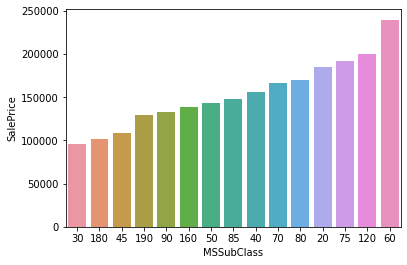

In [9]:
mean_mssub_sale = relative_attribute_sale("MSSubClass",train_data)
sns.barplot(data = mean_mssub_sale,x='MSSubClass',y='SalePrice',order = mean_mssub_sale.sort_values(by = 'SalePrice')['MSSubClass'])

## MSZoning


<AxesSubplot:xlabel='MSZoning', ylabel='SalePrice'>

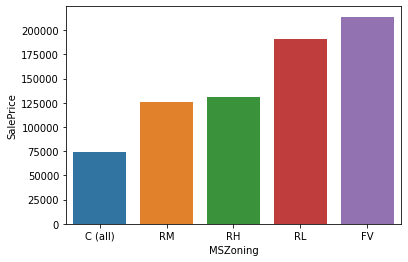

In [10]:
sns.barplot(data = relative_attribute_sale("MSZoning",train_data),x = 'MSZoning',y = 'SalePrice')

RM, RH same? 

## LotFrontage: has NAN

<AxesSubplot:xlabel='LotFrontage', ylabel='SalePrice'>

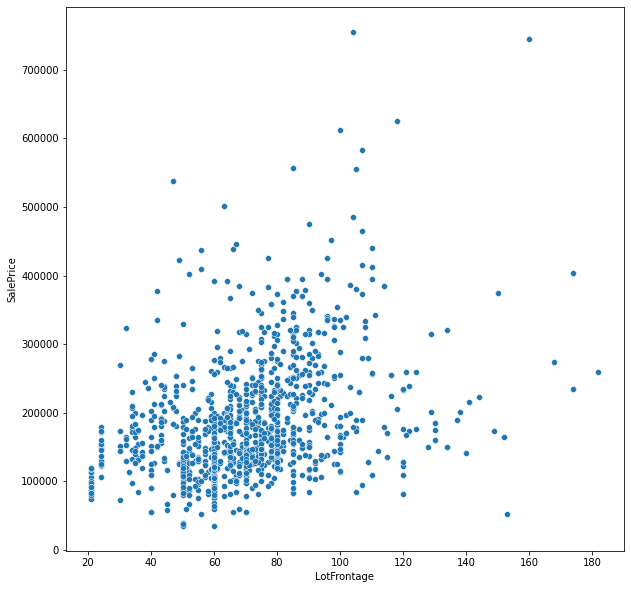

In [45]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x = 'LotFrontage',y= 'SalePrice')

In [12]:
train_data['LotFrontage'] = train_data['LotFrontage'].apply(lambda x: train_data['LotFrontage'].mean() if x > 250 else x)

<AxesSubplot:xlabel='LotFrontage', ylabel='SalePrice'>

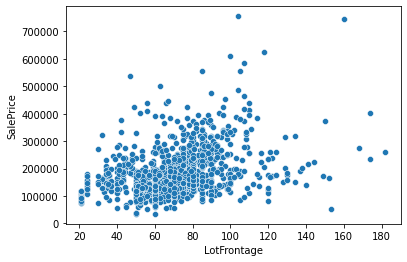

In [13]:
sns.scatterplot(data = train_data,x = 'LotFrontage',y= 'SalePrice')

Sale > 700000?

## Lot Area

<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

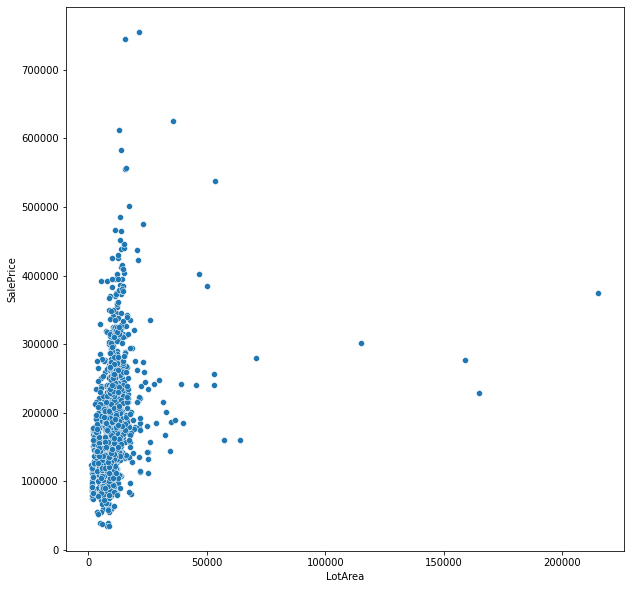

In [14]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x = 'LotArea',y='SalePrice')

In [15]:
mean_lotarea_high_200 = train_data[(train_data['SalePrice'] > 200000) & (train_data['SalePrice'] < 400000)]['LotArea'].mean()

In [16]:
train_data['LotArea'] = train_data['LotArea'].apply(lambda x: mean_lotarea_high_200 if x > 100000 else x) 

<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

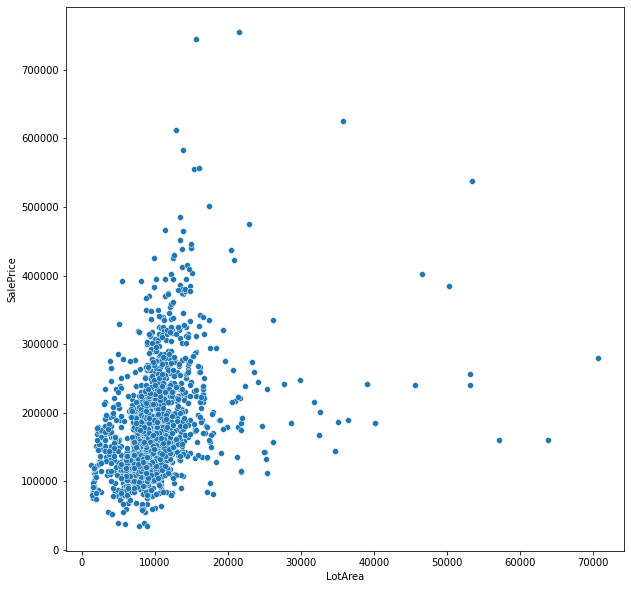

In [17]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = train_data,x = 'LotArea',y='SalePrice')

## Street

In [18]:
train_data['Street'].value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

<AxesSubplot:xlabel='Street', ylabel='SalePrice'>

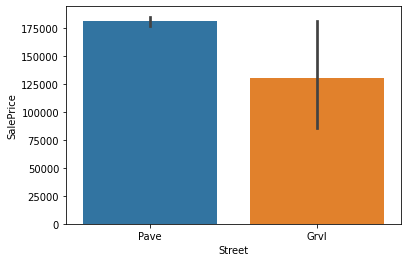

In [19]:
sns.barplot(data = train_data, x = 'Street',y='SalePrice')

## Alley: has NAN

In [20]:
train_data['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [21]:
len(train_data['Alley'].isna())

1460

In [22]:
train_data['Alley'] = train_data['Alley'].fillna(0)


<AxesSubplot:xlabel='Alley', ylabel='SalePrice'>

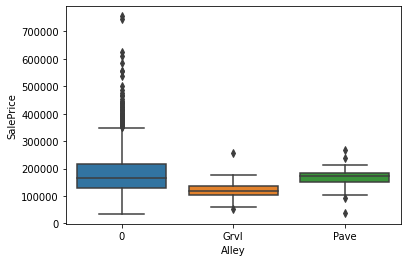

In [23]:
sns.boxplot(data = train_data,x = 'Alley',y='SalePrice')

## LotShape

In [24]:
train_data['LotShape'].value_counts()

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

<AxesSubplot:xlabel='LotShape', ylabel='SalePrice'>

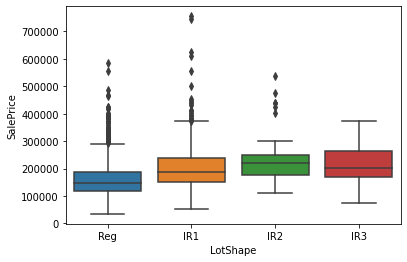

In [25]:
sns.boxplot(data = train_data,x = 'LotShape',y='SalePrice')

## LandContour

<AxesSubplot:xlabel='LandContour', ylabel='SalePrice'>

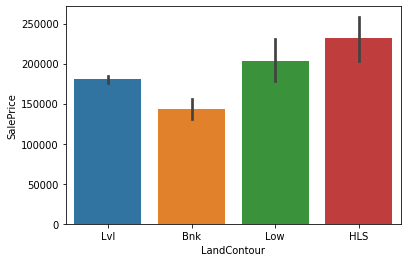

In [26]:
sns.barplot(data = train_data,x = 'LandContour',y='SalePrice')

## Utilities

<AxesSubplot:xlabel='Utilities', ylabel='SalePrice'>

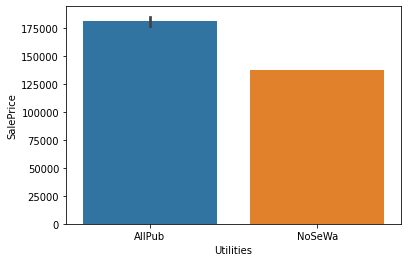

In [27]:
sns.barplot(data = train_data,x = 'Utilities',y='SalePrice')

## LotConfig

<AxesSubplot:xlabel='LotConfig', ylabel='SalePrice'>

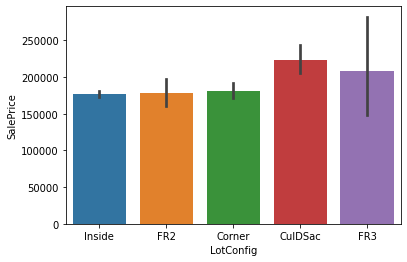

In [28]:
sns.barplot(data = train_data,x='LotConfig',y='SalePrice')

## LandSlope

<AxesSubplot:xlabel='LandSlope', ylabel='SalePrice'>

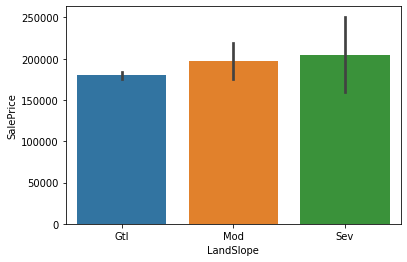

In [29]:
sns.barplot(data = train_data,x='LandSlope',y='SalePrice')

## Neighborhood

In [30]:
train_data['Neighborhood'].value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

<AxesSubplot:xlabel='Neighborhood', ylabel='SalePrice'>

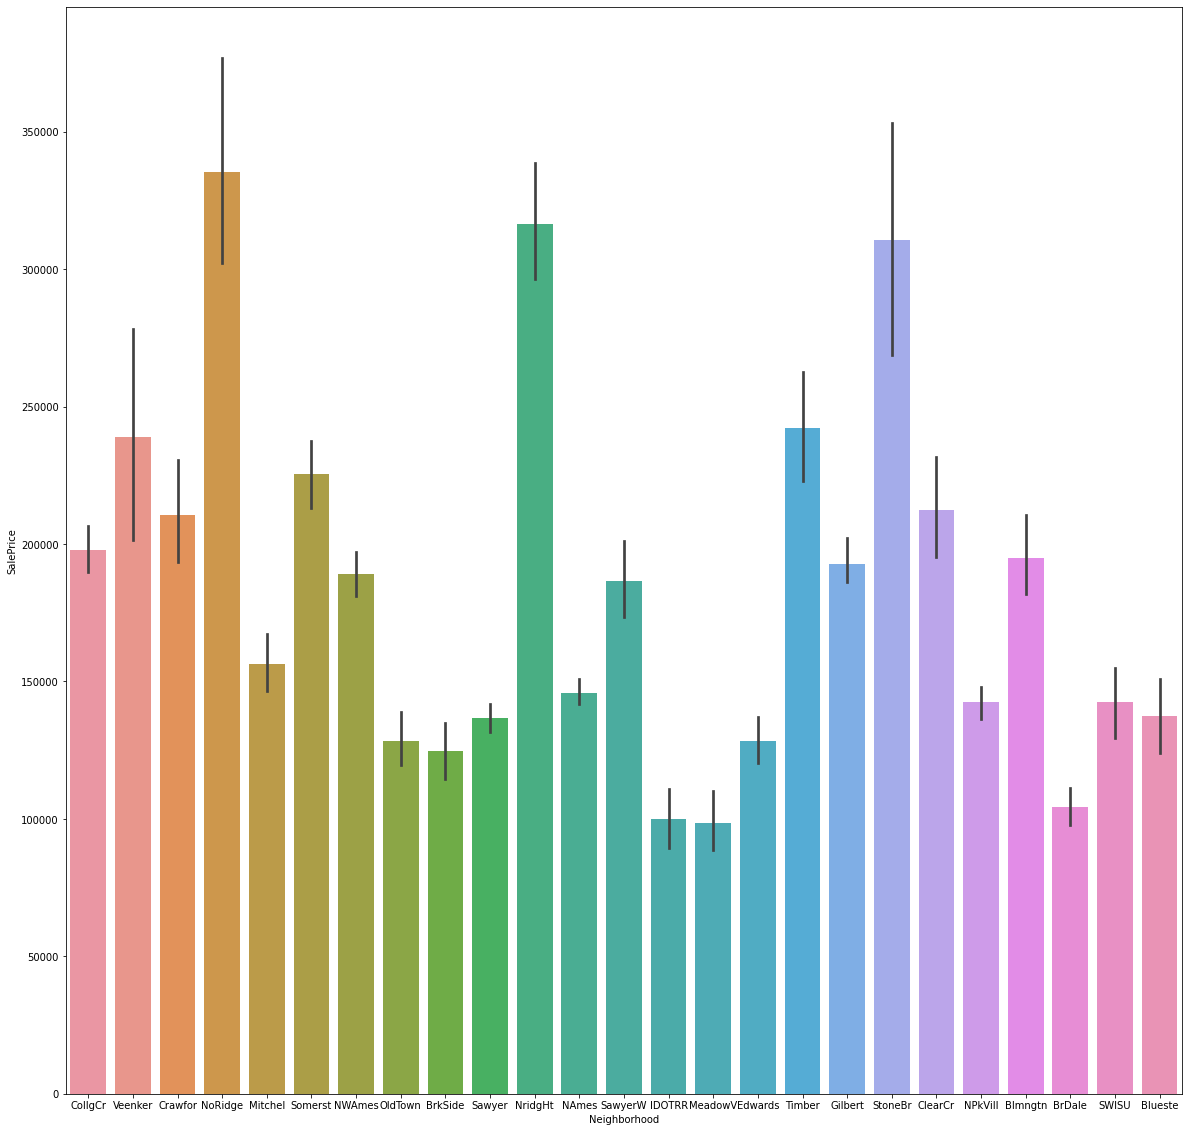

In [31]:
plt.figure(figsize = (20,20))
sns.barplot(data = train_data,x='Neighborhood',y='SalePrice')

group ?

## Condition1 + Condition2

<AxesSubplot:xlabel='Condition1', ylabel='SalePrice'>

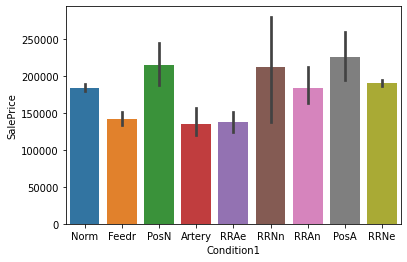

In [32]:
sns.barplot(data = train_data,x = 'Condition1',y='SalePrice')

<AxesSubplot:xlabel='Condition2', ylabel='SalePrice'>

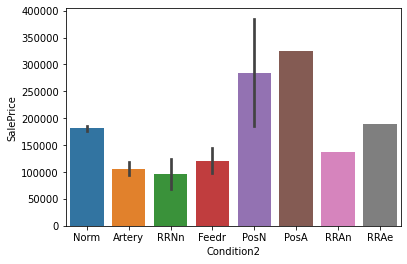

In [33]:
sns.barplot(data = train_data,x = 'Condition2',y='SalePrice')

## BldgType

<AxesSubplot:xlabel='BldgType', ylabel='SalePrice'>

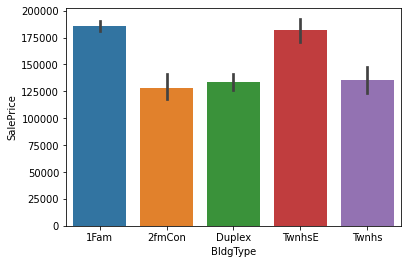

In [34]:
sns.barplot(data = train_data,x='BldgType',y = 'SalePrice')

## HouseStyle

<AxesSubplot:xlabel='HouseStyle', ylabel='SalePrice'>

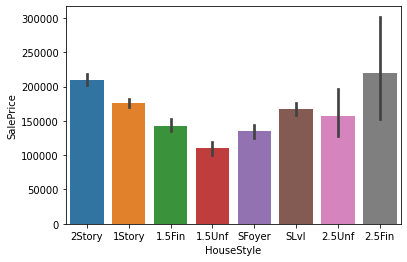

In [35]:
sns.barplot(data = train_data,x='HouseStyle',y = 'SalePrice')

## OverallQual + OverallCond

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

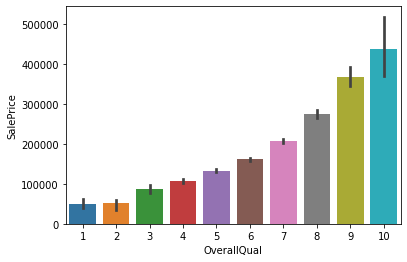

In [36]:
sns.barplot(data = train_data,x='OverallQual',y = 'SalePrice')

<AxesSubplot:xlabel='OverallCond', ylabel='SalePrice'>

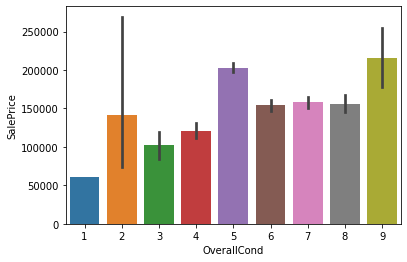

In [37]:
sns.barplot(data = train_data,x='OverallCond',y = 'SalePrice')

why 5 and 2 ? 

## Year Built 

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

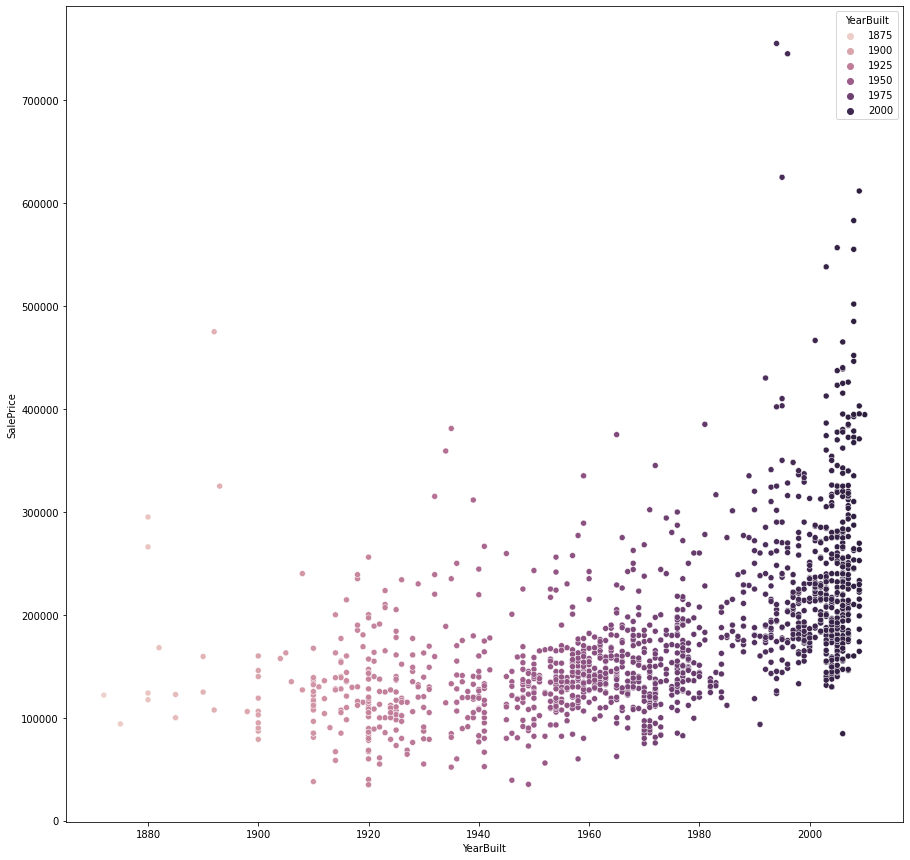

In [40]:
plt.figure(figsize = (15,15))
sns.scatterplot(data = train_data,x='YearBuilt',y='SalePrice',hue = 'YearBuilt')

higher year => higher price

## YearRemodAdd

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

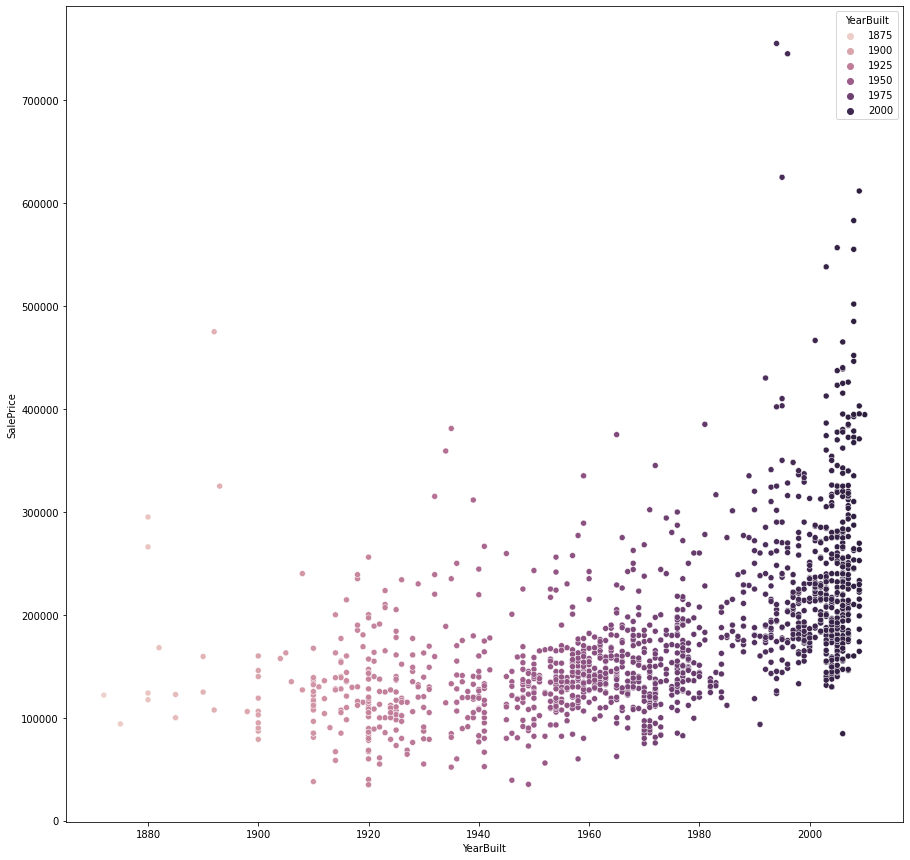

In [43]:
plt.figure(figsize = (15,15))
sns.scatterplot(data = train_data,x='YearBuilt',y='SalePrice',hue = 'YearBuilt')

same as YearBuilt

## RoofStyle

In [44]:
train_data['RoofStyle'].value_counts()

Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64

<AxesSubplot:xlabel='RoofStyle', ylabel='SalePrice'>

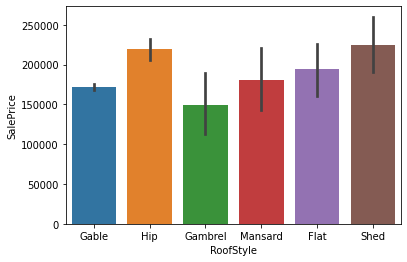

In [46]:
sns.barplot(data = train_data,x='RoofStyle',y='SalePrice')

## RoofMatl

<AxesSubplot:xlabel='RoofMatl', ylabel='SalePrice'>

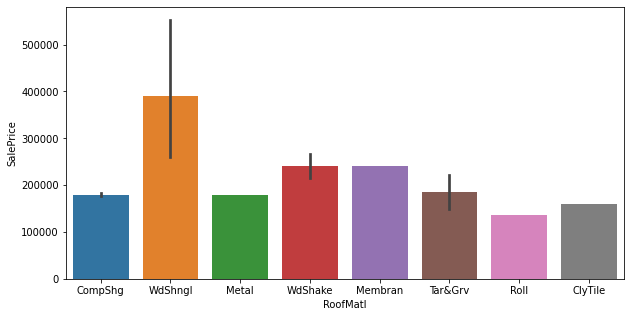

In [48]:
plt.figure(figsize = (10,5))
sns.barplot(data = train_data,x='RoofMatl',y='SalePrice')

## Exterior1st + 2nd

<AxesSubplot:xlabel='Exterior1st', ylabel='SalePrice'>

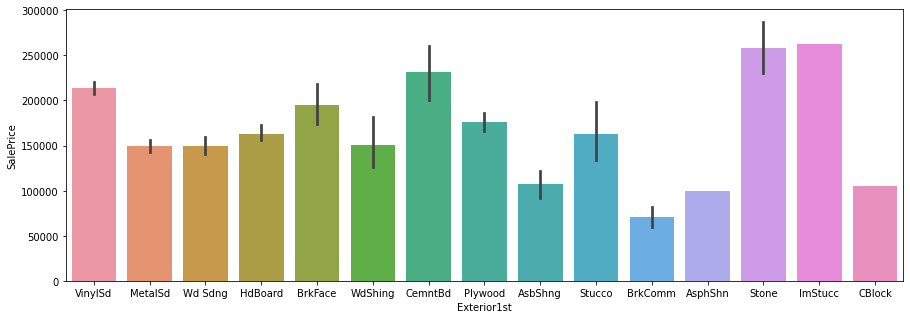

In [54]:
plt.figure(figsize = (15,5))
sns.barplot(data = train_data,x='Exterior1st',y='SalePrice')

<AxesSubplot:xlabel='Exterior2nd', ylabel='SalePrice'>

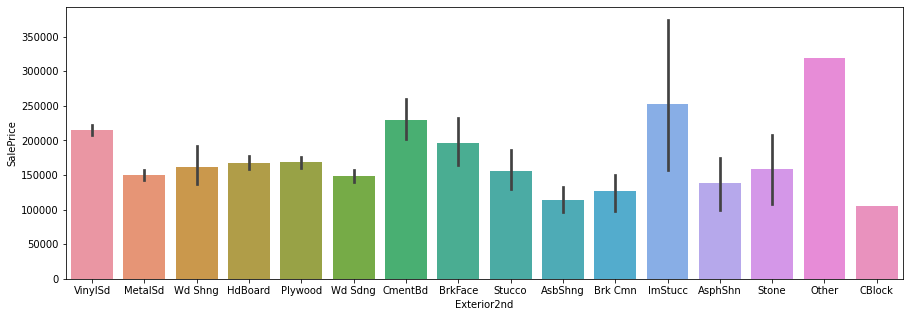

In [55]:
plt.figure(figsize = (15,5))
sns.barplot(data = train_data,x='Exterior2nd',y='SalePrice')